# Million Dollar Burden

"Health care is complicated." It's the joke I keep hearing at every meeting over the past two months and with health data it's absolutly true. Even the most advanced health information systems are left with data that is classified into hundreds of thousands of granular codes. The formats of the documents are then further complicastede with either EDI transactions C-CDA documents, FHIR, or just trying to make sense of a flat-file created for a point-to-point exchange. 

The [Value Set Authority Center](https://vsac.nlm.nih.gov/) lists 15 different code systems that can be used for population health. *(shout out the VSAC is a great resource)* These are as varied as "Health Service Location Codes" which are just 189 codes used to identify the locations of services or SNOMED CT which has over 311,000 concepts for health classification. 

I've heard many IT managers feel like this data is a burden. There is constant flow of ETL jobs amongst various vendors. They group things differently and certain categorizations then are only available in that database or application with no updates until the overnight batch. Well, the data doesn't have to be a burden. With a some simple open source tools you classify millions of rows of claims or clinical data and get immediate results. 

With all of this complexity, it can seem impossible to distill analytics to a broad enough level for it to be consumasble. Many orgainizations turn to vendors who specialize simply in classification and grouping of codes. All in all, categorization can be one of the most signifcant obstacles to starting a health analytics project. But, it shouldn't be with a few simple tools orgnaizations can take advantage of a range of mappings that have been published for research or other purposes. ["Bias to action"](ttps://www.amazon.jobs/principles). Its better to get started with a basic mapping system than to nothing at all. 

## Algorex Categorizer

With this in mind, I wanted to publish this notebook that uses our open-source health categorization functions in a jupyter notebook. When we kick off one of our analytics sprints for a customer, we often start with the steps detailed just so we can have the procedure or diagnosis data categorized before we move forward. You can access the source code on our github page at [CMS Code Categorizer](https://github.com/AlgorexHealth/cms-code-categorizer-python)

What our library does:

1. Provides a basic implementation of categories from the [Health Care Cost Institute](Health Care Cost and Utilization Report: 2011).
2. Provides functions to calculate the correct position of a code in a range of HCPCS codes. Because HCPCS codes are both numeric and alpha-numeric with gaps in the ranges, this is not a simple function. See `is_in_range()` in the source code. 
3. Provides structures for anyone to add their own mapping as a simple python dicionary. you can do this by range or by specific code. 

So lets try it out. 

# Test Data

To test this out, we are going to use the Medicare 2017 fee-schedule which can be accessed at CMS website:

[Medicare 2017 Fee Schedule](https://www.cms.gov/medicare/medicare-fee-for-service-payment/physicianfeesched/).
Specifically, you want the [carrier files for your state](https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/PhysicianFeeSched/PFS-Carrier-Specific-Files.html)

We will use the Mass File for this example PFMA17A

In [2]:
import pandas as pd
import os


In [7]:
df = pd.read_csv('PFMA17A.txt',names=['Year','CarrierNumber','Locality','HCPCS','Modifier','NonFacFee','FacFee','Fill1','Fill2','PCTC','TherapyReduction','insTherapy','OPPSind','OPPSnonFacFee','OPPSFacFee','Trailer','TrailerInd'])

Now, I am going to focus on the Boston locality "1".

In [11]:
boston_fees = df[df['Locality'] == 1]

Now lets import the Algorex Categorization library so that we can use it. The file will need to be in the same directory as the project. 

In [15]:
import categorizer as codes

Before we categorize the whole file, let's look at how it works a little. The main method is `carrier_categorizer_by_hcpc` which will categorize the HCPCS codes. 

So if we wanted to categorize a 99214 Office visit:

In [17]:
codes.carrier_categorizer_by_hcpc('99214')

'Office Visits'

So now lets categorize our whole file. We will add a new column with the category to our dataframe. 

In [58]:
boston_fees = boston_fees.assign(category=boston_fees['HCPCS'].apply(codes.carrier_categorizer_by_hcpc))

In [59]:
boston_fees['category'].value_counts()

Surgery                         5590
Radiology                       1680
Other Professional Services      704
Cardiovascular                   285
Pathology/Lab                    213
Ophthalmology                     95
NOTFOUND                          92
Physical Medicine                 54
Inpatient Visits                  41
Allergy                           25
Immunizations/Injections          19
Office Visits                     19
Psychiatry & Biofeedback          18
Emergency Room/Critical Care      15
Preventive Visits                  9
Name: category, dtype: int64

So as we can see, all the codes were categorized except 92 which were labeled as 'Not Found'. Now why don't we have some fun and see which codes are on average the most expensive:

In [60]:
avg_costs = boston_fees.groupby('category').mean()

In [61]:
import seaborn as sns
%matplotlib inline

/home/vagrant/demo/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


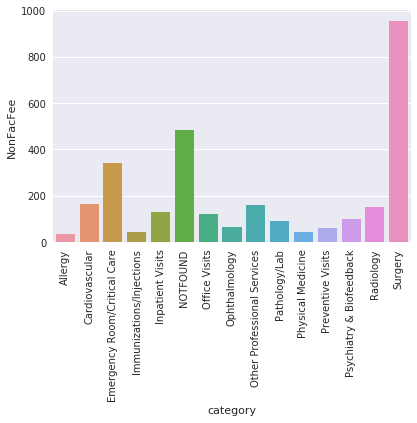

In [62]:
g = sns.factorplot(data=avg_costs.reset_index(), y="NonFacFee", x="category", kind="bar", aspect=1.5)
g.set_xticklabels(rotation=90)


There we go. No real surprise surgery has the highest prices.

# Conclusion

Using the categorizer function, We were able to immediatly categorize almost all 6000 HCPCS codes used the Physician Fee Schedule. It's also extenable to other code sets as well by simply adding rules dictionaries to the underlying codes. So whether you a payer claims file or a bunch of clinical encounters, go ahead and get the basic analytics from it quickly using open-tools like our categorizer and python. 